# 1. Build your own convolutional neural network using pytorch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from skimage import color
from skimage.feature import hog
from sklearn import svm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from typing import OrderedDict
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
from torchmetrics.classification import MulticlassAccuracy
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
batch_size = 64

# transform = transforms.Compose([
#     transforms.Resize((75,75)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

transform = transforms.Compose([
    transforms.Resize((75,75)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [3]:
trainset = torchvision.datasets.ImageFolder(root = 'C:/Users/Nurat/Notes/AI Yeshiva/Sem3/Deep Learning and Neural Networks/Week 3/Homework3/Homework Week3_part_one/Train',transform = transform)
trainloader = DataLoader(trainset, batch_size=batch_size,shuffle = True )

validset = torchvision.datasets.ImageFolder(root = 'C:/Users/Nurat/Notes/AI Yeshiva/Sem3/Deep Learning and Neural Networks/Week 3/Homework3/Homework Week3_part_one/Valid',transform = transform)
validloader = DataLoader(validset, batch_size=batch_size,shuffle = True )

In [4]:
for images, labels in trainloader:
    print("Train images shape:", images.shape)  # Expected shape: [batch_size, 3, 75, 75]
    print("Labels shape:", labels.shape)  # Expected shape: [batch_size]
    break

for images, labels in validloader:
    print("Train images shape:", images.shape)  # Expected shape: [batch_size, 3, 75, 75]
    print("Labels shape:", labels.shape)  # Expected shape: [batch_size]
    break

Train images shape: torch.Size([64, 3, 75, 75])
Labels shape: torch.Size([64])
Train images shape: torch.Size([64, 3, 75, 75])
Labels shape: torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


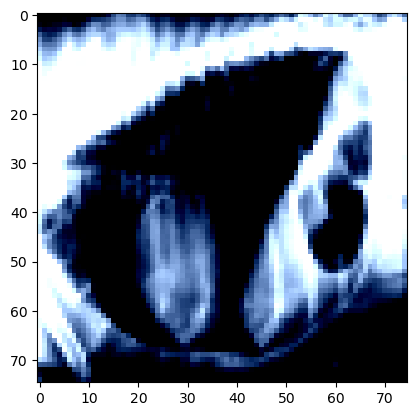

In [5]:
#Checking training data
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Convert to (height, width, channels) for RGB images
plt.imshow(images[0].permute(1, 2, 0), cmap='gray')

In [6]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)  

        return image, self.image_files[idx]

In [7]:
test_dir = 'C:/Users/Nurat/Notes/AI Yeshiva/Sem3/Deep Learning and Neural Networks/Week 3/Homework3/Homework Week3_part_one/Test'
test_dataset = CustomDataset(image_dir=test_dir, transform=transform)
testloader = DataLoader(test_dataset,shuffle = False)

In [17]:
input = torch.randn(32, 3, 75, 75)

#Model 1:

model1 = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,stride=1,padding=1)),  # output = 64,32,75,75
    ('relu1', nn.ReLU()),  # output = 64,32,75,75
    ('conv2', nn.Conv2d(32, 64, 3, 1, 1)),  # output = 64,64,75,75
    ('relu2', nn.ReLU()),  # output = 64, 64, 75, 75
    ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),  # output = 64, 64, 37, 37
    ('conv3', nn.Conv2d(64, 128, 3, 1, 1)),  # output = 64, 128, 37, 37
    ('relu3', nn.ReLU()),  # output = 64, 128, 37, 37
    ('conv4', nn.Conv2d(128, 216, 3, 1, 1)),  # output = 64, 216, 37, 37
    ('relu4', nn.ReLU()),  # output = 64, 216,  37, 37
    ('pool2', nn.MaxPool2d(kernel_size=2, stride=2)),  # output = 64, 216, 18, 18
    ('conv5', nn.Conv2d(216, 128, 3, 1, 1)),  # output = 64, 128, 18, 18
    ('relu5', nn.ReLU()),  # output = 64, 128, 18, 18
    ('conv6', nn.Conv2d(128, 64, 3, 1, 1)),  # output = 64, 64, 18, 18
    ('batchnorm', nn.BatchNorm2d(64)), # output = 64, 64, 18, 18
    ('relu6', nn.ReLU()),  # output = 64, 64, 18, 18
    ('pool3', nn.MaxPool2d(kernel_size=2, stride=2)),  # output = 64, 64, 9, 9
    ('flatten', nn.Flatten()),  # output = 64, 64*9*9
    ('fc1', nn.Linear(64*9*9, 128)),  # output = 64, 128
    ('drop1', nn.Dropout(0.5)),
    ('relu7', nn.ReLU()),  # output = 64, 128
    ('fc2', nn.Linear(128, 64)),  # output = 64, 64
    ('drop2', nn.Dropout(0.5)),
    ('relu8', nn.ReLU()),  # output = 64, 64
    ('fc3', nn.Linear(64, 3)),  # output = 64, 3
]))


#Model 2:

model2 = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,stride=1,padding=1)),  # output = 64,32,75,75
    ('relu1', nn.ReLU()),  # output = 64,32,75,75
    ('conv2', nn.Conv2d(32, 64, 3, 1, 1)),  # output = 64,64,75,75
    ('batchnorm1', nn.BatchNorm2d(64)), # output = 32, 64, 75, 75
    ('relu2', nn.ReLU()),  # output = 64, 64, 75, 75
    ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),  # output = 64, 64, 37, 37
    ('conv3', nn.Conv2d(64, 128, 3, 1, 1)),  # output = 64, 128, 37, 37
    ('relu3', nn.ReLU()),  # output = 64, 128, 37, 37
    ('conv4', nn.Conv2d(128, 216, 3, 1, 1)),  # output = 64, 216, 37, 37
    ('relu4', nn.ReLU()),  # output = 64, 216,  37, 37
    ('pool2', nn.MaxPool2d(kernel_size=2, stride=2)),  # output = 64, 216, 18, 18
    ('conv5', nn.Conv2d(216, 128, 3, 1, 1)),  # output = 64, 128, 18, 18
    ('relu5', nn.ReLU()),  # output = 64, 128, 18, 18
    ('conv6', nn.Conv2d(128, 64, 3, 1, 1)),  # output = 64, 64, 18, 18
    ('batchnorm', nn.BatchNorm2d(64)), # output = 64, 64, 18, 18
    ('relu6', nn.ReLU()),  # output = 64, 64, 18, 18
    ('pool3', nn.MaxPool2d(kernel_size=2, stride=2)),  # output = 64, 64, 9, 9
    ('flatten', nn.Flatten()),  # output = 64, 64*9*9
    ('fc1', nn.Linear(64*9*9, 128)),  # output = 64, 128
    ('drop1', nn.Dropout(0.5)),
    ('relu7', nn.ReLU()),  # output = 64, 128
    ('fc2', nn.Linear(128, 64)),  # output = 64, 64
    ('drop2', nn.Dropout(0.5)),
    ('relu8', nn.ReLU()),  # output = 64, 64
    ('fc3', nn.Linear(64, 3)),  # output = 64, 3
]))
    

model1(input).shape,model1(images).shape,model2(input).shape,model2(images).shape

(torch.Size([32, 3]),
 torch.Size([64, 3]),
 torch.Size([32, 3]),
 torch.Size([64, 3]))

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(128, 216, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(216, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (conv6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu6): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padd

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)
train_accuracy = MulticlassAccuracy(num_classes=3).to(device)
val_accuracy = MulticlassAccuracy(num_classes=3).to(device)

In [20]:
num_epochs = 25
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_no_improve = 0

In [21]:
torch.manual_seed(8)

train_losses = []
val_losses = []

best_val_loss = float('inf')
epochs_no_improve = 0
patience = 10  # Example patience value for early stopping

for epoch in tqdm(range(num_epochs)):
    model2.train()
    running_loss = 0.0

    # Training loop
    for inputs, labels in tqdm(trainloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_accuracy.update(outputs, labels)

    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_accuracy = train_accuracy.compute().item()
    train_accuracy.reset()
    train_losses.append(epoch_train_loss)

    # Validation loop
    model2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(validloader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model2(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy.update(outputs, labels)
            
    epoch_val_loss = val_loss / len(validloader)
    epoch_val_accuracy = val_accuracy.compute().item()
    val_accuracy.reset()
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Train Accuracy: {epoch_train_accuracy:.4f}, "
          f"Validation Loss: {epoch_val_loss:.4f}, "
          f"Validation Accuracy: {epoch_val_accuracy:.4f}")

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

  4%|▍         | 1/25 [00:16<06:45, 16.91s/it]

Epoch 1/25, Train Loss: 1.0549, Train Accuracy: 0.3328, Validation Loss: 1.0893, Validation Accuracy: 0.3333


  8%|▊         | 2/25 [00:33<06:19, 16.52s/it]

Epoch 2/25, Train Loss: 1.0171, Train Accuracy: 0.3410, Validation Loss: 1.0087, Validation Accuracy: 0.3669


 12%|█▏        | 3/25 [00:49<06:00, 16.37s/it]

Epoch 3/25, Train Loss: 0.9655, Train Accuracy: 0.3953, Validation Loss: 0.9772, Validation Accuracy: 0.3810


 16%|█▌        | 4/25 [01:05<05:41, 16.25s/it]

Epoch 4/25, Train Loss: 0.9555, Train Accuracy: 0.4210, Validation Loss: 0.9314, Validation Accuracy: 0.4095


 20%|██        | 5/25 [01:21<05:22, 16.13s/it]

Epoch 5/25, Train Loss: 0.9359, Train Accuracy: 0.4409, Validation Loss: 0.9271, Validation Accuracy: 0.4345


 24%|██▍       | 6/25 [01:37<05:06, 16.12s/it]

Epoch 6/25, Train Loss: 0.9221, Train Accuracy: 0.4564, Validation Loss: 0.9111, Validation Accuracy: 0.4720


 28%|██▊       | 7/25 [01:53<04:48, 16.05s/it]

Epoch 7/25, Train Loss: 0.8688, Train Accuracy: 0.5028, Validation Loss: 0.8813, Validation Accuracy: 0.5207


 32%|███▏      | 8/25 [02:09<04:33, 16.07s/it]

Epoch 8/25, Train Loss: 0.8395, Train Accuracy: 0.5318, Validation Loss: 0.8634, Validation Accuracy: 0.4981


 36%|███▌      | 9/25 [02:25<04:16, 16.02s/it]

Epoch 9/25, Train Loss: 0.8095, Train Accuracy: 0.5685, Validation Loss: 0.7727, Validation Accuracy: 0.6866


 40%|████      | 10/25 [02:41<03:59, 15.99s/it]

Epoch 10/25, Train Loss: 0.8032, Train Accuracy: 0.5900, Validation Loss: 0.7040, Validation Accuracy: 0.7290


 44%|████▍     | 11/25 [02:57<03:44, 16.01s/it]

Epoch 11/25, Train Loss: 0.7733, Train Accuracy: 0.6223, Validation Loss: 0.7791, Validation Accuracy: 0.6970


 48%|████▊     | 12/25 [03:13<03:27, 15.98s/it]

Epoch 12/25, Train Loss: 0.7256, Train Accuracy: 0.6598, Validation Loss: 0.6996, Validation Accuracy: 0.7059


 52%|█████▏    | 13/25 [03:29<03:10, 15.92s/it]

Epoch 13/25, Train Loss: 0.7039, Train Accuracy: 0.6802, Validation Loss: 0.6507, Validation Accuracy: 0.7128


 56%|█████▌    | 14/25 [03:45<02:55, 15.94s/it]

Epoch 14/25, Train Loss: 0.6726, Train Accuracy: 0.6988, Validation Loss: 0.7215, Validation Accuracy: 0.7023


 60%|██████    | 15/25 [04:00<02:38, 15.89s/it]

Epoch 15/25, Train Loss: 0.6501, Train Accuracy: 0.7225, Validation Loss: 0.6183, Validation Accuracy: 0.7566


 64%|██████▍   | 16/25 [04:16<02:23, 15.94s/it]

Epoch 16/25, Train Loss: 0.6276, Train Accuracy: 0.7297, Validation Loss: 0.6648, Validation Accuracy: 0.7101


 68%|██████▊   | 17/25 [04:32<02:06, 15.85s/it]

Epoch 17/25, Train Loss: 0.5698, Train Accuracy: 0.7775, Validation Loss: 0.6333, Validation Accuracy: 0.7601


 72%|███████▏  | 18/25 [04:48<01:51, 15.98s/it]

Epoch 18/25, Train Loss: 0.5379, Train Accuracy: 0.7687, Validation Loss: 0.6261, Validation Accuracy: 0.6818


 76%|███████▌  | 19/25 [05:04<01:36, 16.04s/it]

Epoch 19/25, Train Loss: 0.5240, Train Accuracy: 0.7979, Validation Loss: 0.7068, Validation Accuracy: 0.6231


 80%|████████  | 20/25 [05:21<01:20, 16.09s/it]

Epoch 20/25, Train Loss: 0.5025, Train Accuracy: 0.7952, Validation Loss: 0.5567, Validation Accuracy: 0.7307


 84%|████████▍ | 21/25 [05:37<01:04, 16.12s/it]

Epoch 21/25, Train Loss: 0.4703, Train Accuracy: 0.8333, Validation Loss: 0.5674, Validation Accuracy: 0.7352


 88%|████████▊ | 22/25 [05:53<00:48, 16.07s/it]

Epoch 22/25, Train Loss: 0.4203, Train Accuracy: 0.8446, Validation Loss: 0.6507, Validation Accuracy: 0.7365


 92%|█████████▏| 23/25 [06:09<00:32, 16.08s/it]

Epoch 23/25, Train Loss: 0.3809, Train Accuracy: 0.8686, Validation Loss: 0.7763, Validation Accuracy: 0.7763


 96%|█████████▌| 24/25 [06:25<00:16, 16.03s/it]

Epoch 24/25, Train Loss: 0.3714, Train Accuracy: 0.8608, Validation Loss: 0.5643, Validation Accuracy: 0.7204


100%|██████████| 25/25 [06:41<00:00, 16.05s/it]

Epoch 25/25, Train Loss: 0.3398, Train Accuracy: 0.8829, Validation Loss: 0.6850, Validation Accuracy: 0.7025


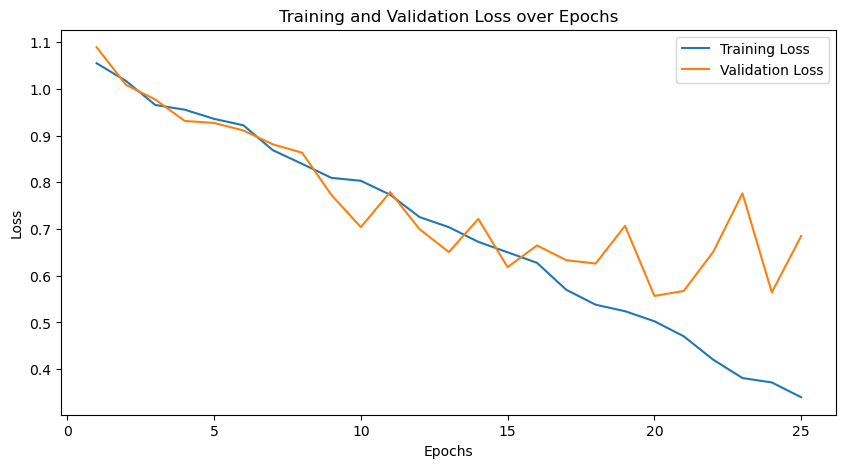

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [25]:
model2.eval()

# List to store predictions
all_predictions = []

# Loop over test data
with torch.no_grad():
    for inputs in tqdm(testloader, desc="Predicting"):
        imputs = inputs[0].to(device)
        outputs = model2(imputs)
        _, preds = torch.max(outputs, 1)
        all_predictions.extend(preds.cpu().numpy())


all_predictions = np.array(all_predictions)

Predicting: 100%|██████████| 400/400 [00:05<00:00, 75.98it/s]


In [26]:
filenames = []
for _, fname in testloader:
    filenames.extend(fname)  # Since batch size is 1, extend is fine here

results_df = pd.DataFrame({
    'Filename': filenames,
    'Prediction': all_predictions
})
results_df.to_csv('nn17.csv', index=False)

In [96]:
# torch.save(model.state_dict(), 'best_model(%).pth')

In [27]:
import gc

model2.cpu()
del model2
gc.collect()
torch.cuda.empty_cache()

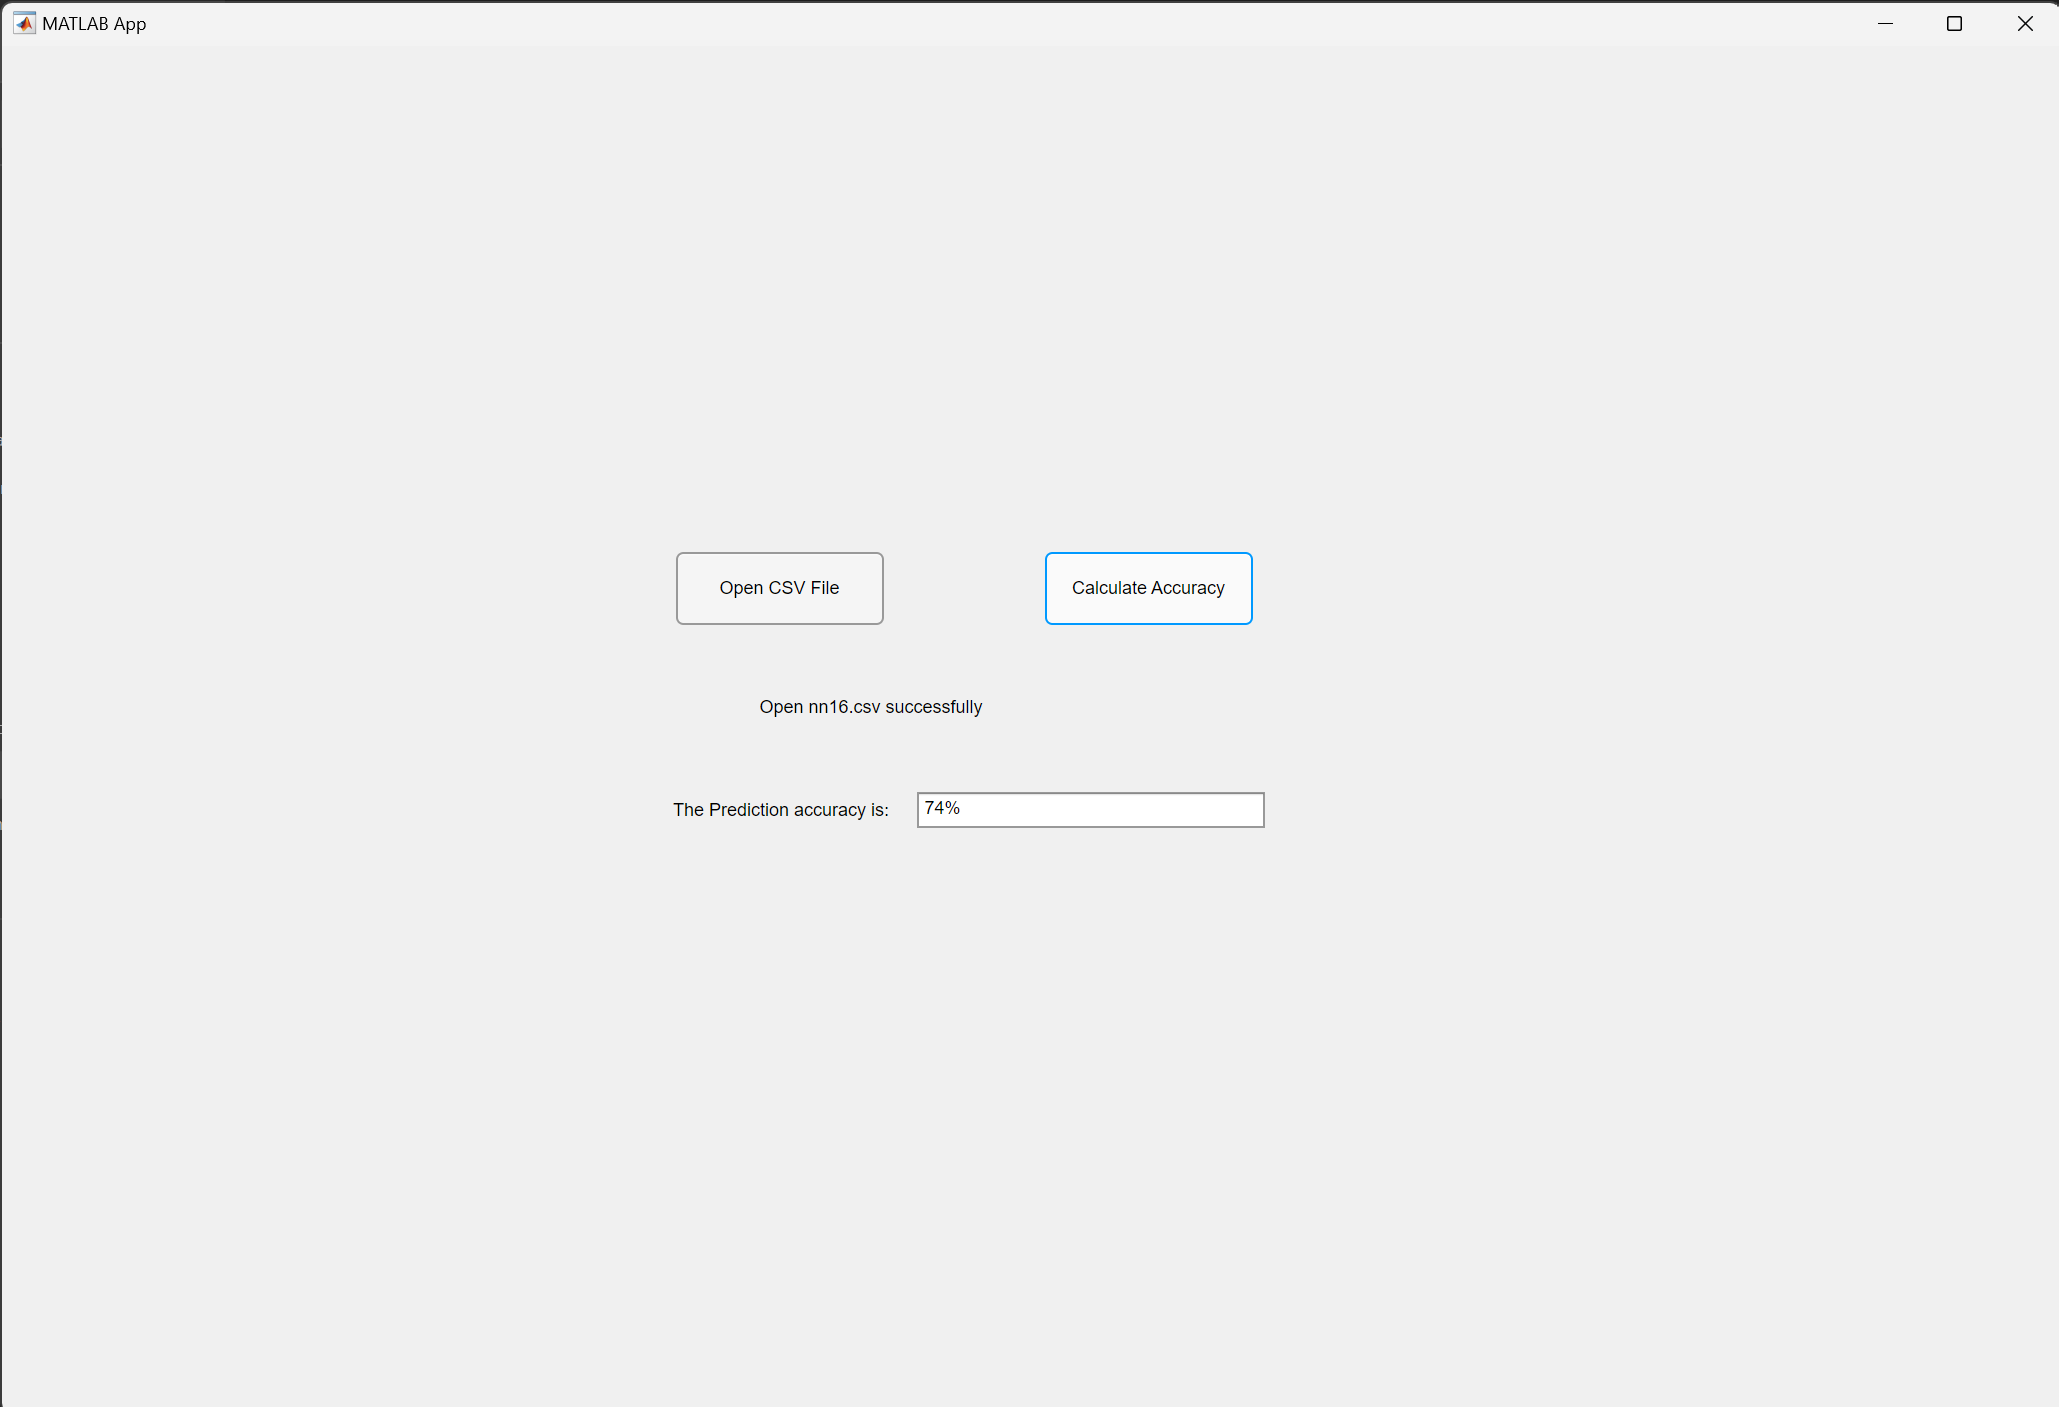

In [1]:
from IPython.display import Image, IFrame

Image('Accuracy.png')